In [1]:
# user specific setup 
# this should work fine as default but you might want to store data 
# other places so feel free to change the paths here

zip_folder = 'data_download_zip/' 
dl_data_folder = 'data/'

base_url = 'https://zenodo.org/record/8204334/files/'

ds20_url = base_url + 'ds20.zip'
ds100_url = base_url + 'ds100.zip'
texas_url = base_url + 'texas.zip'

ds20_zipfile = zip_folder + 'ds20.zip'
ds100_zipfile = zip_folder  + 'ds100.zip'
texas_zipfile = zip_folder + 'texas.zip'

ds20_data_folder = dl_data_folder + 'ds20/'
ds100_data_folder = dl_data_folder + 'ds100/'
texas_data_folder = dl_data_folder + 'texas/'

ds20_model_folder = 'models/ds20/'
ds100_model_folder = 'models/ds100/'
texas_model_folder = 'models/texas/'

EDGE_WGT = 9. 

our_rando_seed = 417417

In [14]:
import h5py
import numpy as np
import torch 
from torch import tensor
import torch.optim as optim
from torch.nn import MSELoss
from torch_geometric.nn import TAGConv 
from torch_geometric.loader import DataLoader
from torch_geometric.data import Data 
import pandas as pd 
from typing import List, Dict, Callable  
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import networkx as nx 
from matplotlib.ticker import PercentFormatter

In [2]:
# loading data 
# This will take maybe 30 seconds initially.  
# Seecond time you should not notice the lag.  

import os 
from requests import get 

def mkdir_if_not_exist(folder):
    if not os.path.exists(folder):
        os.makedirs(folder)

def make_path_if_not_exist(file):
    folder = os.path.dirname(file)
    mkdir_if_not_exist(folder)

def load_from_source(url, file, overwrite=False):
    make_path_if_not_exist(file)
    if not os.path.exists(file) or overwrite:
        with open(file, 'wb') as f:
            response = get(url)
            f.write(response.content)
            print(f"Downloaded {url} to {file}")
            f.close()

    else:
        print(f"File {file} already exists. Set overwrite=True to overwrite")

load_from_source(ds20_url, ds20_zipfile)
load_from_source(ds100_url, ds100_zipfile)
load_from_source(texas_url, texas_zipfile)

File data_download_zip/ds20.zip already exists. Set overwrite=True to overwrite
File data_download_zip/ds100.zip already exists. Set overwrite=True to overwrite
File data_download_zip/texas.zip already exists. Set overwrite=True to overwrite


In [3]:


# now extract from zip files and load the data 

import zipfile

def extract_zip(zipfile_name, folder):
    zf = zipfile.ZipFile(zipfile_name)
    zf.extractall(folder)
    zf.close()

extract_zip(ds20_zipfile, dl_data_folder)
extract_zip(ds100_zipfile, dl_data_folder)

# re-structure data so we can throw that into the data loader 



In [12]:
# read in hd5 data 
# This is quite slow, taking about 3 minutes.  



def load_data(ds: str, type:str, data_folder:str, batch_size=500) -> DataLoader:  

    folder_name = f"{data_folder}/{ds}/{type}/"

    file_name_input = f"{folder_name}/input_data.h5"
    file_name_snbs = f"{folder_name}/snbs.h5"

    snbs_data = h5py.File(file_name_snbs, 'r')
    input_data = h5py.File(file_name_input, 'r')['grids']

    grid_data = [
        Data(
            x = tensor(np.array(id_v['node_features']).reshape(-1, 1), dtype=torch.float),
            edge_index = tensor(np.array(id_v['edge_index']).T - 1, dtype=torch.long),
            edge_attr = tensor(np.full(shape=id_v['edge_index'].shape[0], fill_value=EDGE_WGT), dtype=torch.float),
            y = tensor(np.array(snbs_v), dtype=torch.float)
        )
        for id_v, snbs_v in zip(input_data.values(), snbs_data.values())
    ]

    return DataLoader(grid_data, batch_size=batch_size)

def load_dataset(ds:str, data_folder: str) -> Dict[str, DataLoader]: 
    res= dict() 
    res['train_ds'] = load_data(ds=ds, type='train', data_folder=data_folder)
    res['test_ds'] = load_data(ds=ds, type='test', data_folder=data_folder)
    res['valid_ds'] = load_data(ds=ds, type='valid', data_folder=data_folder)
    return res 

data_ds20 = load_dataset('ds20', dl_data_folder)
data_ds100 = load_dataset('ds100', dl_data_folder)




KeyboardInterrupt: 

In [6]:
from load_data import load_from_source, extract_zip, load_dataset

In [7]:
# test how the dtaset looks like 

print(data_ds20['train_ds'].dataset[0].y)

tensor([0.9999, 1.0000, 0.9807, 0.8151, 0.9770, 0.8541, 0.8983, 0.7800, 0.8480,
        0.8558, 0.9656, 0.9257, 0.8025, 0.6902, 0.6636, 0.8054, 0.7192, 0.7492,
        0.8234, 0.7749])


In [15]:
class TAGConvModule(torch.nn.Module):
    def __init__(self, channels_in, channels_out, K_hops, activation, batch_norm) -> None:
        super().__init__()
        self.channels_in = channels_in
        self.channels_out = channels_out
        self.K_hops = K_hops
        self.activation = activation
        self.batch_norm = batch_norm

        self.conv = TAGConv(
            self.channels_in, 
            self.channels_out, 
            K=self.K_hops
        )
        if self.batch_norm:
            self.batch_norm_layer = torch.nn.BatchNorm1d(self.channels_out)

    def forward(self, data, x):
        # Add safety checks
        num_nodes = x.size(0)
        if data.edge_index.max() >= num_nodes:
            raise ValueError(f"Edge index contains invalid node indices. Max index: {data.edge_index.max()}, num nodes: {num_nodes}")
        
        if data.edge_index.min() < 0:
            raise ValueError(f"Edge index contains negative indices: {data.edge_index.min()}")
            
        # Apply convolution
        x = self.conv(x, data.edge_index, data.edge_attr)
        
        if self.batch_norm:
            x = self.batch_norm_layer(x)
        
        x = self.activation(x)
        return x
    
class TAGNet(torch.nn.Module):
    def __init__(
        self, 
        no_layers: int,
        channels: List[int],
        activation: List[Callable],
        K_hops: List[int],
        batch_norm: List[bool],
        final_linear_layer: bool,
        final_sigmoid_layer: bool = True, 
    ) -> None:
        super(TAGNet, self).__init__()

        self.no_layers = no_layers
        self.channels = channels
        self.activation = activation
        self.K_hops = K_hops
        self.batch_norm = batch_norm
        self.final_linear_layer = final_linear_layer
        self.final_sigmoid_layer = final_sigmoid_layer


        self.convlist = torch.nn.ModuleList([
            TAGConvModule(
                channels_in=self.channels[i],
                channels_out=self.channels[i+1],
                activation=self.activation[i],
                K_hops=self.K_hops[i],
                batch_norm=self.batch_norm[i]
            )
            for i in range(self.no_layers)
        ])

        if self.final_linear_layer:
            self.endLinear = torch.nn.Linear(self.channels[-1], 1)
        if self.final_sigmoid_layer: 
            self.endSigmoid = torch.nn.Sigmoid()

    def forward(self, data):
        x = data.x
        
        for conv in self.convlist:
            x = conv(data, x)
            
        if self.final_linear_layer:
            x = self.endLinear(x)
        if self.final_sigmoid_layer: 
            x = self.endSigmoid(x)
        
        return x.squeeze(-1)  # Match target shape

from torchmetrics import R2Score

class TAGModule(torch.nn.Module): 
    def __init__(
        self, 
        channels, 
        activation,
        K_hops,
        batch_norm,
        final_linear_layer, 
        final_sigmoid_layer
    ) -> None:
        
        torch.manual_seed(our_rando_seed)
        torch.cuda.manual_seed(our_rando_seed)
        np.random.seed(our_rando_seed)        

        super(TAGModule, self).__init__()
        self.model = TAGNet(
            no_layers=len(channels) - 1,
            channels=channels,
            activation=activation,
            K_hops=K_hops,
            batch_norm=batch_norm,
            final_linear_layer=final_linear_layer,
            final_sigmoid_layer=final_sigmoid_layer
        )
        self.device = torch.device('cpu')
        self.model.to(self.device)
        self.criterion = MSELoss(reduction='mean')
        self.optimizer = optim.SGD(
            self.model.parameters(), lr=3, momentum=0.9
        ) 

        self.scheduler = optim.lr_scheduler.StepLR(
            self.optimizer, step_size=10, gamma=0.1
        )

        self.r2score = R2Score().to(self.device)
    
    def forward(self, x): 
        return self.model(x)

    def train_epoch(self, data_loader, threshold=0.1): 
        self.model.train() 
        all_labels = torch.Tensor(0).to(self.device)
        all_preds = torch.Tensor(0).to(self.device)
        correct = 0 
        for _, (batch) in enumerate(data_loader):
            batch.to(self.device)
            self.optimizer.zero_grad()
            outputs = torch.squeeze(self.model.forward(batch))
            loss = self.criterion(outputs, batch.y)
            loss.backward()
            self.optimizer.step()
            correct += torch.sum(( torch.abs(outputs-batch.y) < threshold ))
            all_labels = torch.cat([all_labels, batch.y])
            all_preds = torch.cat([all_preds, outputs])

        accuracy = correct / all_labels.shape[0]
        r2_score = self.r2score(all_preds, all_labels)

        return accuracy, r2_score

    def eval_model(self, data_loader, threshold=0.1): 
        self.model.eval() 
        correct = 0 
        all_labels = torch.Tensor(0).to(self.device)
        all_preds = torch.Tensor(0).to(self.device)

        with torch.no_grad(): 
            for _, (batch) in enumerate(data_loader):
                batch.to(self.device)
                outputs = torch.squeeze(self.model(batch))
                correct += torch.sum(( torch.abs(outputs-batch.y) < threshold ))
                all_labels = torch.cat([all_labels, batch.y])
                all_preds = torch.cat([all_preds, outputs])

        accuracy = correct / all_labels.shape[0]
        r2_score = self.r2score(all_preds, all_labels)

        return accuracy, r2_score
        

# Update your model initialization
tag_net = TAGNet(
    no_layers=3,
    channels=[1, 32, 32, 1],  # Make sure dimensions match
    activation=[torch.nn.ReLU()] * 3,
    K_hops=[2] * 3,
    batch_norm=[True] * 3, 
    final_linear_layer=True
)

tag_module = TAGModule(
    channels=[1, 30, 30, 1],
    activation=[torch.nn.ReLU()] * 3,
    K_hops=[3] * 3,
    batch_norm=[True] * 3,
    final_linear_layer=False,
    final_sigmoid_layer=True
)


def make_tag_module(num_layers, num_channels, num_hops): 
    return TAGModule(
        channels=[1] + [num_channels] * (num_layers - 1) + [1],
        activation=[torch.nn.ReLU()] * num_layers,
        K_hops=[num_hops] * num_layers,
        batch_norm=[True] * num_layers,
        final_linear_layer=False,
        final_sigmoid_layer=True
    )

In [16]:
# use now TAGModule to train model 


def train_model(tag_module, data_loader, epochs, patience_limit=50, print_at=None):
    best_so_far = -np.inf
    patienc_eused=0
    all_train_acc = [] 
    all_train_r2 = [] 
    all_test_acc = [] 
    all_test_r2 = [] 
    
    for epoch in range(epochs):
        train_acc, train_r2 = tag_module.train_epoch(data_loader['train_ds'], threshold=0.05)
        valid_acc, valid_r2 = tag_module.eval_model(data_loader['valid_ds'], threshold=0.05)
        if valid_r2 > best_so_far:
            best_so_far = valid_r2
            patienc_eused = 0
        else:
            patienc_eused += 1
            if patienc_eused > patience_limit:
                print(f"Early stopping at epoch {epoch}")
                break
        if print_at: 
            if epoch % print_at == 0:
                print(f"Epoch {epoch}: Train accuracy: {train_acc:.2f}, Train R2: {train_r2:.2f}, Valid accuracy: {valid_acc:.2f}, Valid R2: {valid_r2:.2f}")

        all_train_acc.append(float(train_acc))
        all_train_r2.append(float(train_r2.item()))
        all_test_acc.append(float(valid_acc))
        all_test_r2.append(float(valid_r2.item()))

    hist = {
        'train_acc': np.array(all_train_acc), 
        'train_r2': np.array(all_train_r2), 
        'valid_acc': np.array(all_test_acc), 
        'valid_r2': np.array(all_test_r2), 
    }
    return hist 



In [18]:

NL = [4, 5, 6, 7] 
NC = [20, 30, 40]  
NH = [4, 5, 6, 7]

hp_idx = [
    (nl, nc, nh) 
    for nl in NL 
    for nc in NC  
    for nh in NH 
]

model_dict = dict() 
hist_dict = dict() 

#make dir trained_models/ if not exists 
for subdir in [
        'trained_models_ds20', 'training_hist_ds20', 
        'trained_models_ds100', 'training_hist_ds100', 
    ]:  
    if not os.path.exists(subdir):
        os.makedirs(subdir)

print("="*20)
print("="*20) 
print("20 NODE TRAINING SET")

for idx in hp_idx: 
    print("="*20)
    print(f'Training {str(idx)}..')
    model_dict[idx] = make_tag_module(
        num_layers=idx[0], 
        num_channels=idx[1], 
        num_hops = idx[2]
        )
    hist_dict[idx] = train_model(
        model_dict[idx], 
        data_ds20, 
        epochs = 400, 
        patience_limit=10, 
        print_at=10
    )

    torch.save(model_dict[idx], f'trained_models_ds20/model_{str(idx)}.pth') 
    # transform hist dict into json and save too 
    tmp_dict = {
        k: list(v) 
        for k, v in hist_dict[idx].items() 
    }
    import json 
    json.dump(
        tmp_dict, 
        open(f'training_hist_ds20/{str(idx)}.pth', 'w') 
        )


print("="*20)
print("="*20) 
print("100 NODE TRAINING SET")

for idx in hp_idx: 
    print("="*20)
    print(f'Training {str(idx)}..')
    model_dict[idx] = make_tag_module(
        num_layers=idx[0], 
        num_channels=idx[1], 
        num_hops = idx[2]
        )
    hist_dict[idx] = train_model(
        model_dict[idx], 
        data_ds20, 
        epochs = 400, 
        patience_limit=10, 
        print_at=10
    )

    torch.save(model_dict[idx], f'trained_models_ds100/model_{str(idx)}.pth') 
    # transform hist dict into json and save too 
    tmp_dict = {
        k: list(v) 
        for k, v in hist_dict[idx].items() 
    }
    import json 
    json.dump(
        tmp_dict, 
        open(f'training_hist_ds100/{str(idx)}.pth', 'w') 
        )




20 NODE TRAINING SET
Training (4, 20, 4)..
Epoch 0: Train accuracy: 0.20, Train R2: -2.29, Valid accuracy: 0.22, Valid R2: -1.67
Epoch 10: Train accuracy: 0.57, Train R2: 0.50, Valid accuracy: 0.56, Valid R2: 0.48


KeyboardInterrupt: 

KeyError: (4, 20, 4)

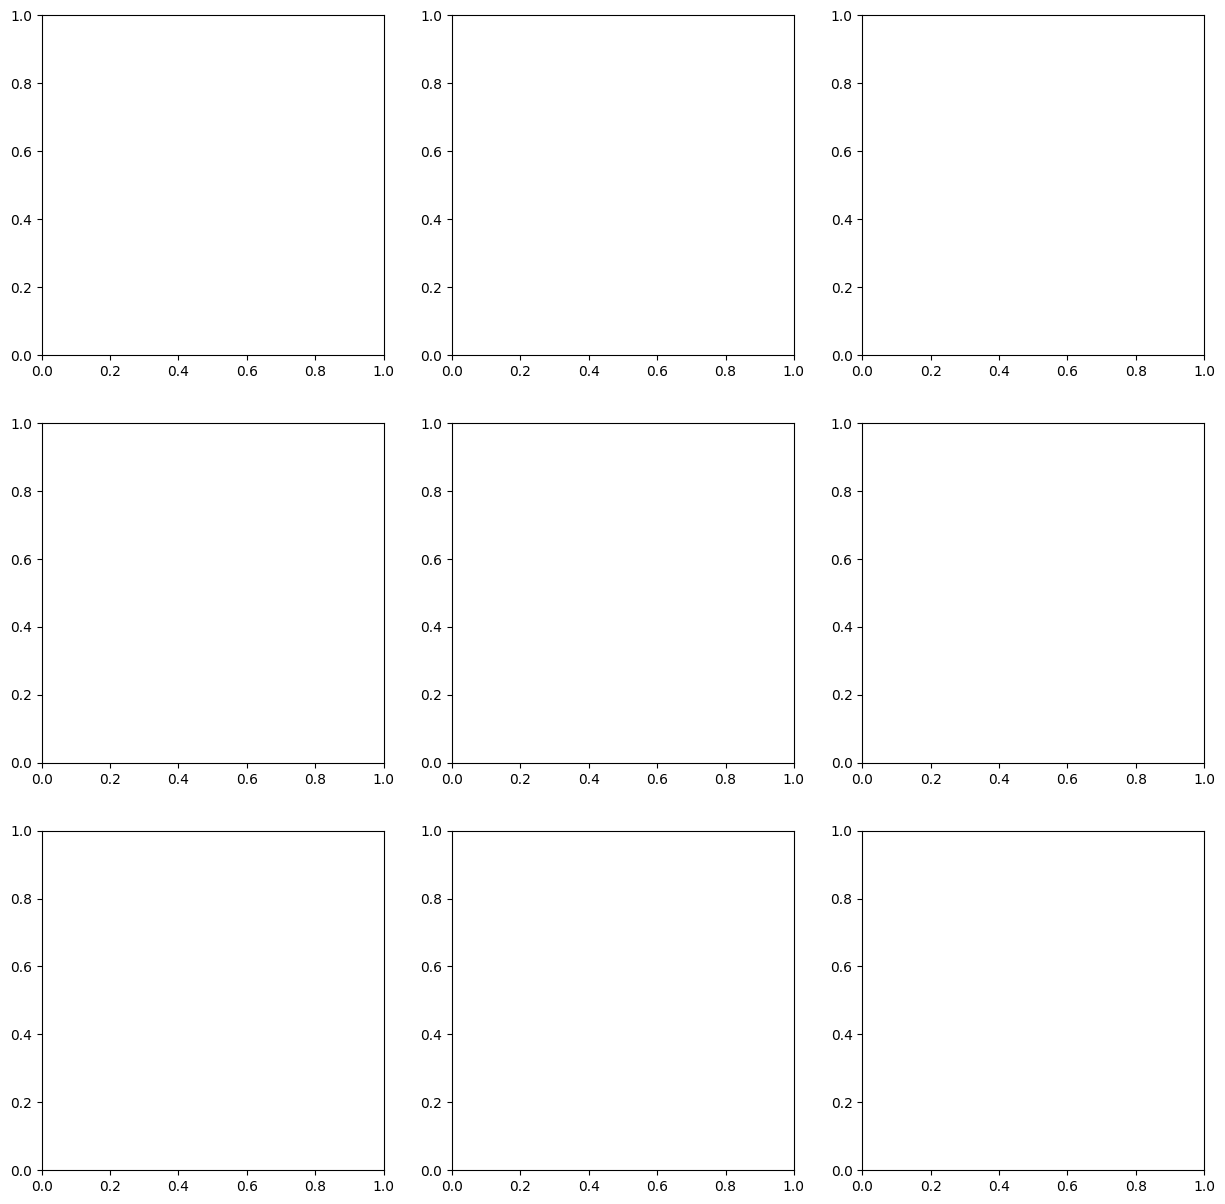

In [19]:
from matplotlib import pyplot as plt 
# we dissect the indices again 
fig, axs = plt.subplots(3, 3, figsize=(15, 15))

for i, nl in enumerate([4, 5, 6]): 
    for j, nc in enumerate([20, 30, 50]): 
        ax = axs[i,j]
        for nh in [4, 5, 6]: 
            ts = hist_dict[(nl, nc, nh)]['valid_r2']
            epochs = np.arange(len(ts))
            idx_plt = np.arange(25, len(ts))
            ax.plot(epochs[idx_plt], ts[idx_plt], label=str(nh) + " hops")
            ax.legend()
            ax.set_ylim(0.4,0.8)
            ax.grid()
            ax.set_title(f"{nl} layers, {nc} channels")

plt.show() 





In [ ]:
# We now extract some random graph and color it with red-green color map based on the label

import matplotlib.pyplot as plt
import networkx as nx 
from matplotlib.ticker import PercentFormatter

def plot_graph(
        data, node_labels, ax=None, 
        title=None, node_size=100, 
        legend_cmap=None):
    
    edges = data.edge_index.numpy()
    if ax is None:
        fig, ax = plt.subplots()
    
    ax.set_title(title)
    ax.set_aspect('equal')

    G = nx.Graph()
    G.add_nodes_from(range(node_labels.shape[0]))
    G.add_edges_from(edges.T)

    pos = nx.kamada_kawai_layout(G)
    
    # Draw the graph
    nodes = nx.draw_networkx_nodes(
        G, pos, ax=ax, node_color=node_labels, 
        cmap='RdYlGn', node_size=node_size
        )
    edges = nx.draw_networkx_edges(G, pos, ax=ax)
    
    if legend_cmap:
        # Add colorbar with percentage formatting 
        # name legend_cmap to put in as label of legend 
        cbar = plt.colorbar(nodes, ax=ax)
        cbar.set_label(legend_cmap)
        cbar.ax.yaxis.set_major_formatter(
            PercentFormatter(xmax=1.0, decimals=0)
            )
    
    return ax

data = data_ds20['train_ds'].dataset[0]
snbs = data.y.numpy()   
P = data.x.numpy() 
pred_snbs = tag_module(data).detach().numpy()

_, axs = plt.subplots(1, 3, figsize=(15, 5))

plot_graph(data, P, ax=axs[0], title='Source/Sink')
plot_graph(data, snbs, ax=axs[1], title='True SNBS', legend_cmap="SNBS")
plot_graph(data, pred_snbs, ax=axs[2], title='Predicted SNBS', legend_cmap="predicted SNBS")

plt.show()



In [ ]:


def plot_graph(
        data, node_labels, ax=None, 
        title=None, node_size=100, 
        cmap='RdYlGn',
        vmin=None, vmax=None,
        add_colorbar=False,
        colorbar_label=None):
    
    edges = data.edge_index.numpy()
    if ax is None:
        fig, ax = plt.subplots()
    
    ax.set_title(title)
    ax.set_aspect('equal')

    G = nx.Graph()
    G.add_nodes_from(range(node_labels.shape[0]))
    G.add_edges_from(edges.T)

    pos = nx.kamada_kawai_layout(G)

    nx.draw_networkx_nodes(
        G, pos, ax=ax,
        node_color='black',  # ring color
        node_size=node_size  + min(max(40., 0.4*node_size), 20.),  # slightly larger size for the ring
    )
    # Draw the graph
    nodes = nx.draw_networkx_nodes(
        G, pos, ax=ax, node_color=node_labels, 
        cmap=cmap, node_size=node_size,
        vmin=vmin, vmax=vmax  # Add these parameters for consistent color scaling
        )
    edges = nx.draw_networkx_edges(G, pos, ax=ax)
    
    if add_colorbar:
        # Add colorbar with percentage formatting
        cbar = plt.colorbar(nodes, ax=ax)
        if colorbar_label:
            cbar.set_label(colorbar_label)
        cbar.ax.yaxis.set_major_formatter(
            PercentFormatter(xmax=1.0, decimals=0)
            )
    


def plt_snbs(data, pred_snbs, node_size=100):

    P = data.x.numpy()
    snbs = data.y.numpy()

    # Create the plot with equal sizes and shared colorbar
    fig = plt.figure(figsize=(15, 5))
    gs = fig.add_gridspec(1, 3, width_ratios=[1, 1, 1.2])  # Slightly wider last subplot for colorbar

    axs = [fig.add_subplot(gs[0, i]) for i in range(3)]

    # Get the full range of values for consistent colormap
    vmin = min(snbs.min(), pred_snbs.min())
    vmax = max(snbs.max(), pred_snbs.max())


    # Plot each graph

    # first graph gets a purple/orange colormap 
    plot_graph(
        data, P, ax=axs[0], 
        title='Grid, Source (purple) / Sink (red)', 
        vmin=-1, vmax=1, cmap=mcolors.ListedColormap(['purple', 'orange']), 
        node_size=node_size
        )

    plot_graph(data, snbs, ax=axs[1], title='True SNBS', vmin=vmin, vmax=vmax, 
        node_size=node_size)
    nodes = plot_graph(data, pred_snbs, ax=axs[2], title='Predicted SNBS', 
                    vmin=vmin, vmax=vmax, add_colorbar=True, 
                    colorbar_label='SNBS', 
        node_size=node_size)

    plt.tight_layout()

data = data_ds100['train_ds'].dataset[0]
pred_snbs = tag_module(data).detach().numpy()
plt_snbs(data, pred_snbs, node_size=30)
plt.savefig('sample_graph_100.png')
plt.show()

data = data_ds20['train_ds'].dataset[0]
pred_snbs = tag_module(data).detach().numpy()
plt_snbs(data, pred_snbs, node_size=100)
plt.savefig('sample_graph_20.png')
plt.show()




In [ ]:
node_size=100. 
min(max(20., 0.3*node_size), 10.)
